#### Network analysis on the interactions between users of r\WallStreetBets
In this notebook, a directed graph will be constructed from the interactions between people posting on the subreddit and the people commenting on them.
Later, some general statistics on the graph will be computed, followed by an authority vs hub analysis and a thorough visualization.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
data = pd.read_pickle('post_comments')

In [3]:
df = pd.DataFrame(data, 
                  columns=['post_id', 'post_user', 'comment_id', 'comment_user'])

In [4]:
df_new = df.groupby(['post_user', 'comment_user']).size().reset_index()

In [5]:
df_new['weight'] = df_new[0]
df_new = df_new.drop(columns=[0])
df_new

,post_user,comment_user,weight
0,---------II---------,Inevita92,1
1,---------II---------,eidorianc,1
2,---------II---------,only1parkjisung,1
3,------TooyBooy------,bobfreehuman,1
4,------what------,jaymancini,1
...,...,...,...
2039741,zzzzzz129,grebfar,5
2039742,zzzzzz129,theycallme1,2
2039743,zzzzzz129,wallstreetboyfriend,3
2039744,zzzzzzzzzzzzzqqqqqqq,DunderMuggler,1


In [105]:
G = nx.from_pandas_edgelist(df_new, source='comment_user', target='post_user', 
                            edge_attr='weight', create_using=nx.DiGraph())

In [7]:
nodes = list(df_new.sample(10000).post_user)
nodes[:5]

['After_Layer6588', 'carrros', 'Hentitan', 'Cadet_Xero', 'ArcticGold']

In [8]:
G = G.subgraph(nodes)

In [106]:
G.number_of_nodes() 

637395

In [107]:
G.number_of_edges()

2039746

In [109]:
N, K = G.number_of_nodes() , G.number_of_edges()
avg_deg = float(K) / N
avg_deg

3.200128648640168

In [11]:
in_degrees = list(G.in_degree()) # dictionary node:degree
in_values = sorted(set([in_degree[1] for in_degree in in_degrees]))
in_hist = [[in_degree[1] for in_degree in in_degrees].count(x) for x in in_values]

<ipython-input-133-f372c9d95eaf>:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 2*10**2])


(0.6188500645217611, 200)

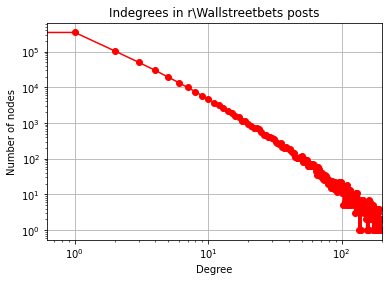

In [133]:
plt.figure() # you need to first do 'import pylab as plt'
plt.grid(True)
plt.loglog(in_values, in_hist, 'ro-') # in-degree
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Indegrees in r\Wallstreetbets posts')
plt.xlim([0, 2*10**2])

In [12]:
G_ud = G.to_undirected()
avg_clustering = nx.average_clustering(G_ud)
print(avg_clustering)   

0.23324925867365323


In [13]:
from collections import Counter

def get_top_keys(dictionary, top):
    items = Counter(dictionary).most_common(top)
    return items

# Connected components are sorted in descending order of their size
G_mc = max(nx.connected_components(G_ud), key=len)
G_S = G_ud.subgraph(G_mc).copy()

In [14]:
# Betweenness centrality
bet_cen = nx.betweenness_centrality(G_S)
top_bet_cen = get_top_keys(bet_cen,10)
top_bet_cen

[('OPINION_IS_UNPOPULAR', 0.6472338066386908),
 ('AutoModerator', 0.30374507559845904),
 ('[deleted]', 0.05929871263884435),
 ('GoBeaversOSU', 0.029256150533507358),
 ('Bundaga', 0.013044959202834407),
 ('speakinexistencebro', 0.010128241577837255),
 ('does-it-mater', 0.009537363509509848),
 ('Parliament--', 0.009288929562322239),
 ('DawudM', 0.009182207693844096),
 ('anchelus', 0.006561235467391775)]

In [15]:
# Closeness centrality
clo_cen = nx.closeness_centrality(G_S)
top_clo_cen = get_top_keys(clo_cen,10)
top_clo_cen

[('OPINION_IS_UNPOPULAR', 0.7219480798111994),
 ('AutoModerator', 0.6198765773233859),
 ('[deleted]', 0.5255759468957438),
 ('GoBeaversOSU', 0.48424233702691033),
 ('zjz', 0.4714205659848697),
 ('FreakingOutTheNGHBRD', 0.4683368128044537),
 ('SnooWalruses7854', 0.4674909697138094),
 ('Lazy_Dragonfruit_727', 0.4667128987517337),
 ('Sasha_Storm', 0.4660664819944598),
 ('Parliament--', 0.4656472704628797)]

In [16]:
# Eigenvector centrality
eig_cen = nx.eigenvector_centrality(G_S)
top_eig_cen = get_top_keys(eig_cen,10)
top_eig_cen

[('OPINION_IS_UNPOPULAR', 0.5511760177783362),
 ('AutoModerator', 0.3992824891912545),
 ('[deleted]', 0.11555847160275086),
 ('GoBeaversOSU', 0.09244230645871235),
 ('zjz', 0.04853826201368468),
 ('Bundaga', 0.03472101052542549),
 ('praguepride', 0.029284215220779827),
 ('SnooWalruses7854', 0.02926814257494643),
 ('WorriedBanker', 0.028413419343100967),
 ('moonski', 0.026844439549557758)]

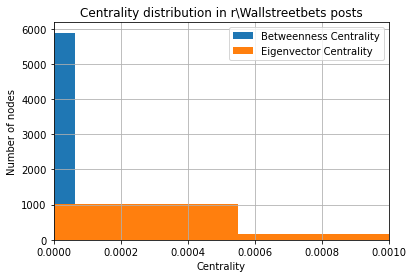

In [93]:
# distribution of centralities
plt.figure() # you need to first do 'import pylab as plt'
plt.grid(True)
plt.hist(np.array(list(bet_cen.values())), label='Betweenness Centrality', bins=10000) # in-degree
#plt.hist(np.array(list(clo_cen.values()))/20, label='Closeness Centrality', bins=1000) # in-degree
plt.hist(np.array(list(eig_cen.values())), label='Eigenvector Centrality', bins=1000) # in-degree
plt.xlabel('Centrality')
plt.ylabel('Number of nodes')
plt.title('Centrality distribution in r\Wallstreetbets posts')
plt.xlim([0, 0.001])
plt.legend()

In [17]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(G_ud))
sorted(c[0])

['--KillerTofu--',
 '--ok',
 '--ph',
 '-7r4v15-',
 '-Anonymously-',
 '-EAT-MY-SHORTS-',
 '-Listening',
 '-Mage-Knight-',
 '-Mr-Popo-',
 '-NotEvenMyFinalForm-',
 '-Qwerty--',
 '-R3DF0X',
 '-Reverence-',
 '-SPM-',
 '-Starflight-',
 '-Tuber-',
 '-Workin-it-',
 '-_Ven_-',
 '-a_bot-',
 '-cheeseman673723',
 '-day-dreamer-',
 '-expletive-deleted-',
 '-iwl-',
 '-jujubean-',
 '-justsomegirl',
 '-libertyordeath-',
 '-paraZite',
 '-procrastinate-',
 '-rigga',
 '-xMrMx-',
 '00101001000111',
 '0010110101102011',
 '007fan007',
 '01000101010001010',
 '052801',
 '0Bubs0',
 '0nlyGoesUp',
 '0verlyManlyMan',
 '0wlbear',
 '0x97',
 '0xCr0v4x',
 '1-Of-Everything',
 '100GHz',
 '100geese',
 '10AMinUzbekistan',
 '10before15',
 '10sptuna',
 '1122Sl110',
 '12294830754',
 '123maga',
 '13Jhm13',
 '152057',
 '16tones_',
 '18Shorty60',
 '19mad95',
 '1VentiChloroform',
 '1_________________11',
 '1artvandelay',
 '1ekane',
 '1lyric',
 '1nf3ct3d',
 '20CharacterUsernames',
 '20Log',
 '20buxiz20bux',
 '21932989',
 '21Dawg

2669
[1, 2, 6731]


Text(0.5, 1.0, 'Community sizes in r\\Wallstreetbets posts')

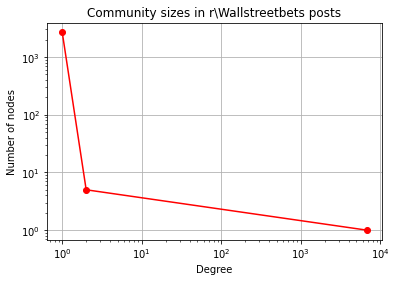

In [78]:
print(len(c)) 
values = sorted(set([len(cc) for cc in c]))
print(values)
hist = [[len(cc) for cc in c].count(x) for x in values]
plt.figure() # you need to first do 'import pylab as plt'
plt.grid(True)
plt.loglog(values, hist, 'ro-') # in-degree
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Community sizes in r\Wallstreetbets posts')

In [79]:
len([len(cc) for cc in c if len(cc) > 2])

1

In [137]:
from networkx.algorithms.link_analysis.hits_alg import hits
h, a = nx.hits(G)
Counter(a).most_common(20)

[('[deleted]', 0.042791061639248944),
 ('dogeball40', 0.0009081929528642265),
 ('iamchromes', 0.0008963537974357835),
 ('MangoManYummy', 0.0008492060678121758),
 ('nosalute', 0.0007088010587853259),
 ('Halizones', 0.0006987139570287178),
 ('GoBeaversOSU', 0.0006849156811297568),
 ('bowtiewonder', 0.0006587370968132452),
 ('ifblueiwas2', 0.0006558638561616221),
 ('oregon_forever', 0.0006460846883699535),
 ('Early_Forever1058', 0.0006410419138257106),
 ('badgerbacon6', 0.000583504198051615),
 ('giantwashcapsfan8', 0.0005800917767138041),
 ('mikemechanics', 0.0005298981444959313),
 ('FaithlessnessFree331', 0.0005290467497886705),
 ('JawnxWick', 0.0005226589507924219),
 ('STONKS_ONLY_GO_UP3', 0.0005189312071389952),
 ('hshamza', 0.0005157852064799397),
 ('Prestigious_Count_62', 0.0005134220043637907),
 ('disneysinger', 0.0005029588313566837)]

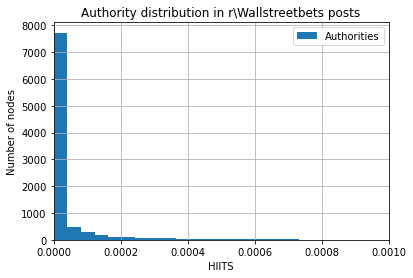

In [100]:
from networkx.algorithms.link_analysis.hits_alg import hits
h, a = nx.hits(G)

plt.figure() # you need to first do 'import pylab as plt'
plt.grid(True)
plt.hist(np.array(list(a.values())), label='Authorities', bins=10000) # in-degree
plt.xlabel('HIITS')
plt.ylabel('Number of nodes')
plt.title('Authority distribution in r\Wallstreetbets posts')
plt.xlim([0, 0.001])
plt.legend()

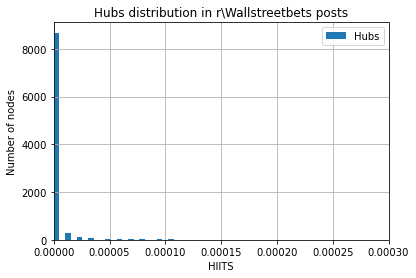

In [102]:
plt.figure() # you need to first do 'import pylab as plt'
plt.grid(True)
plt.hist(np.array(list(h.values())), label='Hubs', bins=100000) # in-degree
plt.xlabel('HIITS')
plt.ylabel('Number of nodes')
plt.title('Hubs distribution in r\Wallstreetbets posts')
plt.xlim([0, 0.0003])
plt.legend()
f.savefig('linkpost_breakdown.png', bbox_inches = 'tight', dpi = 300)


In [138]:
Counter(h).most_common(20)

[('OPINION_IS_UNPOPULAR', 0.2615056183102393),
 ('AutoModerator', 0.20799957658265567),
 ('wallstreetboyfriend', 0.04441123780805574),
 ('MotorizedDoucheCanoe', 0.041426001596699784),
 ('grebfar', 0.03741629179005534),
 ('theycallmeryan', 0.018991393937579804),
 ('ITradeBaconFutures', 0.016553157461450124),
 ('GoBeaversOSU', 0.013194867101506259),
 ('Stylux', 0.012134810056618728),
 ('theycallme1', 0.009250510604073899),
 ('DeepFuckingValue', 0.007699020300412647),
 ('SignedUpWhilePooping', 0.006025095566740748),
 ('premier_', 0.00572871929410383),
 ('bawse1', 0.002773589760826366),
 ('CallsOnAlcoholism', 0.0026646267046126684),
 ('zjz', 0.002269519289940211),
 ('dhiral1994', 0.0016081786134267944),
 ('keenfeed', 0.0014033257682097657),
 ('SubstantialTent', 0.001340148987097453),
 ('SomeGuyInDeutschland', 0.001116601791256455)]

In [18]:
from networkx.algorithms.reciprocity import overall_reciprocity
rec = overall_reciprocity(G)
rec

0.017089914070375883

In [19]:
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
len_shortest = nx.average_shortest_path_length(G_S)

In [20]:
len_shortest

2.549983741589059

Text(0.5, 1.0, '\\rWallStreetBets subgraph displaying degree centrality')

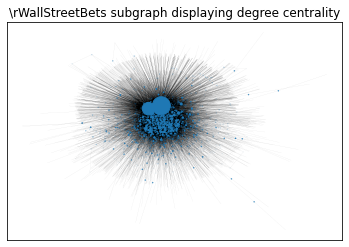

In [104]:
import numpy as np
nx.draw_networkx(G_S, with_labels=False, arrows=False, width=0.02, node_size=500*np.array(list(bet_cen.values())))
plt.title('\\rWallStreetBets subgraph displaying degree centrality')

In [34]:
np.array(list(bet_cen)).size

6731

In [35]:
G_S.number_of_nodes() 

6731

In [108]:
N, K = G_S.number_of_nodes() , G_S.number_of_edges()
avg_deg = float(K) / N
avg_deg

3.066112019016491

In [110]:
nx.diameter(G_S)

8

In [111]:
G_mc = nx.connected_components(G_ud)

In [112]:
G_mc

<generator object connected_components at 0x000001CEDFF36C10>

In [118]:
i = 0
lens = []

for f in G_mc:
    i += 1

i, lens

(0, [])